In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, patches
from numpy.random import default_rng
from tqdm import tqdm

from src.data.loaders.ascad import ASCADData
from src.data.preprocess.hw import full_states, hamming_weights
from src.tools.plotter import init_plots, store_sns
from src.tvla.cri import rho_test
from src.tvla.tvla import prepare_tvla

init_plots()

# Hamming weight extractor

- Extracts the Hamming weight of the state after the SBox in the first round.
- Appends a hamming weight column to the ASCAD file.

In [2]:
ASCAD_RAW = ASCADData.raw()

In [3]:
IXS = np.arange(len(ASCAD_RAW['traces']))
profile_mask = np.ones(len(IXS)).astype(bool)
profile_mask[2::3] = False

In [4]:
rng = default_rng(seed=42)
num_traces = 10000
detect_ixs = IXS[profile_mask][:num_traces]
lim = max(detect_ixs)

In [5]:
RAW_TRACES = ASCAD_RAW['traces']
RAW_META = ASCAD_RAW['metadata']

full_key_ix = 1
plaintext_ix = 0

trace_len = ASCAD_RAW['traces'].shape[1]
traces = np.zeros((num_traces, trace_len), dtype=np.int8)

profile_key, profile_plain = np.zeros((num_traces, 16), dtype=np.uint8), np.zeros((num_traces, 16), dtype=np.uint8)

for i, ascad_i in tqdm(zip(range(num_traces), detect_ixs), total=num_traces):
      traces[i] = RAW_TRACES[ascad_i]
      profile_key[i] = RAW_META[ascad_i][full_key_ix]
      profile_plain[i] = RAW_META[ascad_i][plaintext_ix]

ASCAD_RAW.close()

100%|██████████| 10000/10000 [00:22<00:00, 451.66it/s]


### Calculate full intermediate states from AES

Based on plaintext and key metadata.

In [6]:
profile_states = full_states(np.array(profile_plain), np.array(profile_key))

100%|██████████| 10000/10000 [00:02<00:00, 3424.87it/s]


In [7]:
profile_hw = hamming_weights(profile_states[:, 0, 0])
profile_hw_masked = hamming_weights(profile_states[:, 0, 2])

<AxesSubplot:>

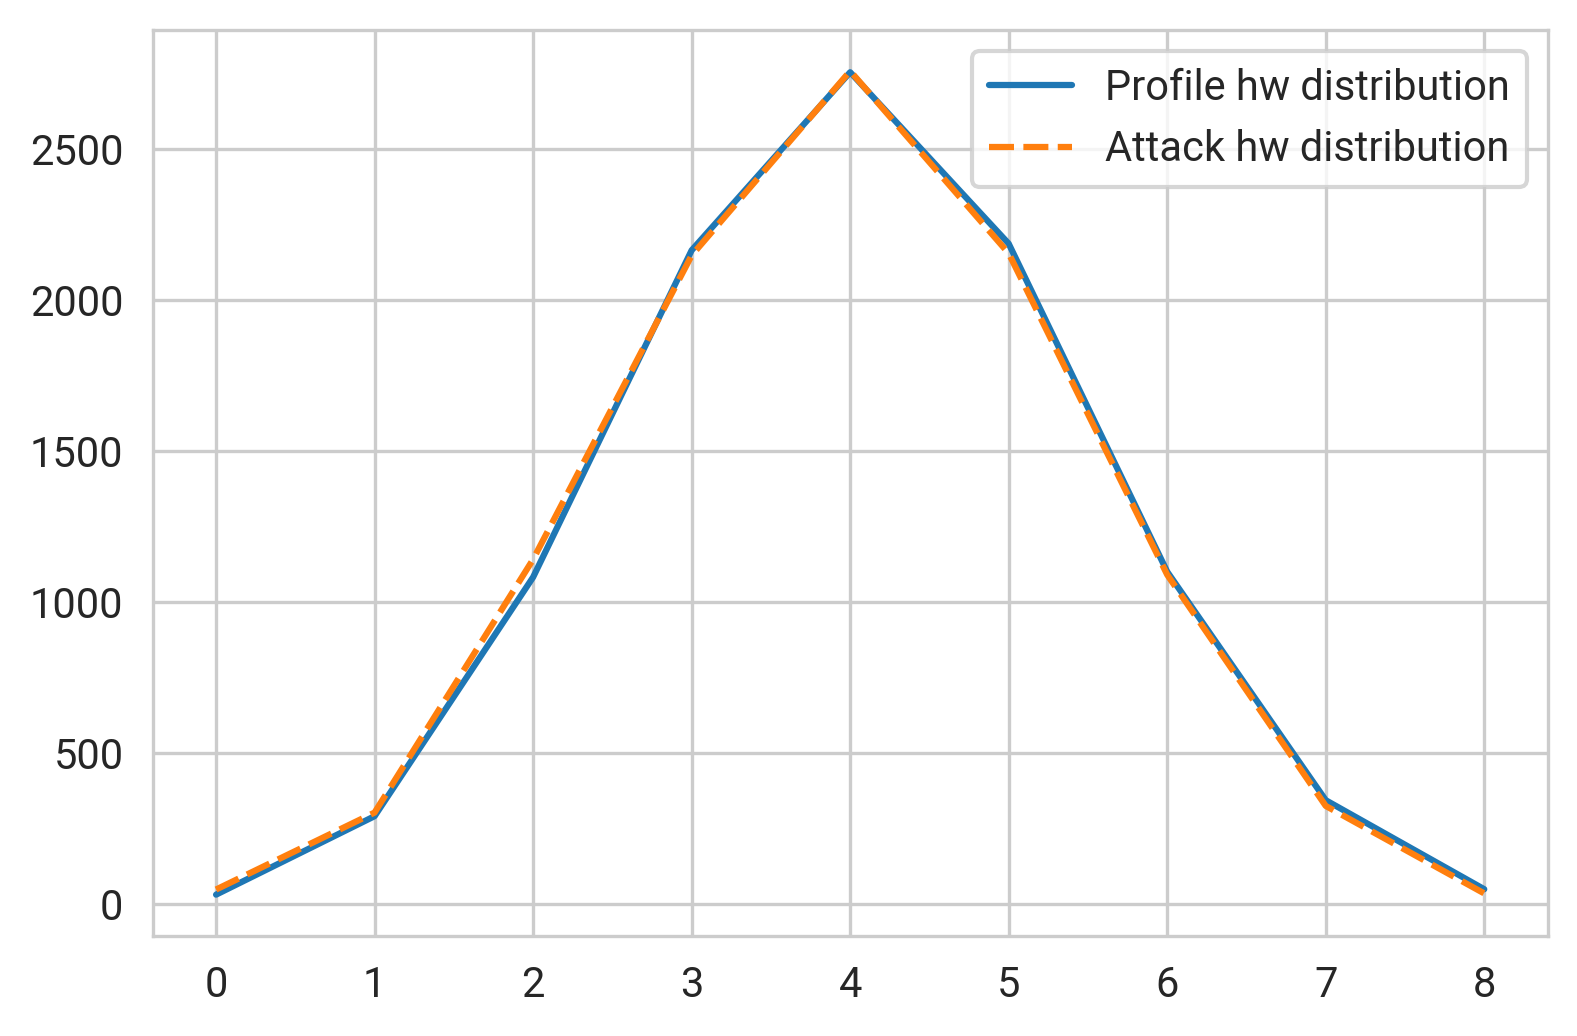

In [8]:
sns.lineplot(data={
    "Profile hw distribution": np.bincount(profile_hw),
    "Attack hw distribution": np.bincount(profile_hw_masked),
})

In [9]:
traces

array([[ 37,  46,  43, ..., -87, -87, -86],
       [ 45,  48,  45, ..., -86, -87,   0],
       [ 38,  39,  33, ..., -87, -87,   0],
       ...,
       [ 46,  53,  49, ..., -85, -85, -87],
       [ 35,  43,  42, ..., -87, -87, -84],
       [ 41,  45,  41, ..., -87, -87,   0]], dtype=int8)

In [10]:
tvla_x, tvla_y = prepare_tvla(traces, profile_hw)
PVS = rho_test(tvla_x, tvla_y)

Computing Correlation Coefficients: 100%|██████████| 250000/250000 [00:41<00:00, 6068.62it/s]


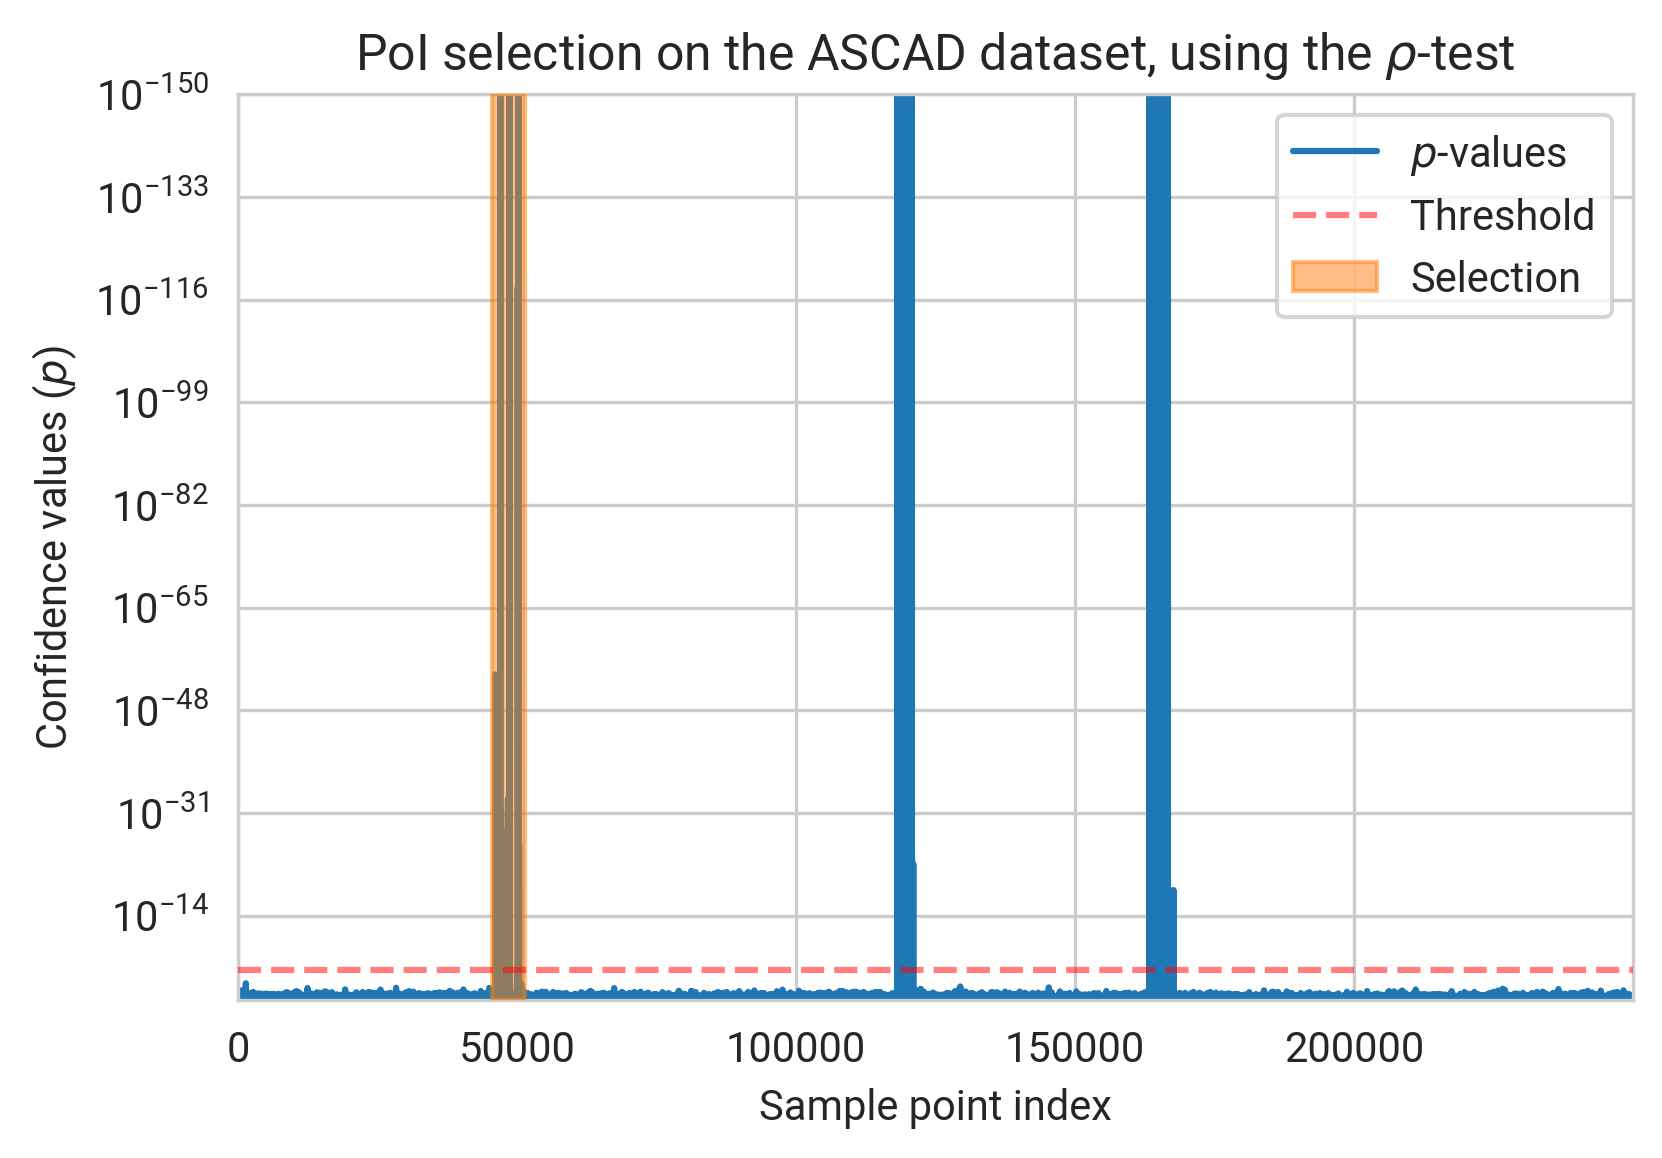

In [22]:
STEP = 10
IX = np.arange(len(PVS[0]), step=STEP)
G = sns.lineplot(data=pd.DataFrame({"$p$-values": PVS[0][::STEP]}, index=IX))

START = 45500
END = START + 1977 * 3
HIGHLIGHT = sns.color_palette()[1]
plt.axvspan(START, END, color=HIGHLIGHT, alpha=.5, zorder=100)
sns.lineplot(y=[10 ** -5] * len(IX), x = IX, color="#FF000080", linestyle="--", label="Threshold", zorder=101)
G.set(yscale="log", ylim=(1, 10 ** -150), xlim=(0, max(IX)), xlabel="Sample point index", ylabel="Confidence values ($p$)",
      title="PoI selection on the ASCAD dataset, using the $\\rho$-test")

handles, labels = G.get_legend_handles_labels()
patch = patches.Patch(color=HIGHLIGHT, alpha=.5, label='Selection')
handles.append(patch)
plt.legend(handles=handles)
store_sns(G, "poi-ascad-none")